# Conditional Generative Adversarial Network (CGAN)

## Import Modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
from IPython.display import clear_output

## Conditional GAN (Model) 

In [2]:
class ConditionalGAN():
  def __init__(self, noise_dim, gen_lr=1e-4, disc_lr=1e-4):
    self.noise_dim = noise_dim
    self.cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    self.generator_optimizer = tf.keras.optimizers.Adam(lr=gen_lr)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(lr=disc_lr)

    self.generator = self.create_generator()    
    self.discriminator = self.create_discriminator()
    self.gan = self.create_gan()
  
  def create_generator(self):
    label_inp = tf.keras.layers.Input(shape=(1,))
    label = tf.keras.layers.Embedding(10, 7 * 7)(label_inp)
    label = tf.keras.layers.Reshape((7, 7, 1))(label)

    noise_inp = tf.keras.layers.Input(shape=(100,))
    merge = tf.keras.layers.Dense(7 * 7)(noise_inp)
    merge = tf.keras.layers.Reshape((7, 7, 1))(merge)
    merge = tf.keras.layers.Concatenate()([merge, label])

    model = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same')(merge)
    model = tf.keras.layers.BatchNormalization()(model)
    model = tf.keras.layers.LeakyReLU(0.2)(model)
    model = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(model)
    model = tf.keras.layers.BatchNormalization()(model)
    model = tf.keras.layers.LeakyReLU(0.2)(model)
    model = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')(model)

    model = tf.keras.Model(inputs=[noise_inp, label_inp], outputs=model, name='Generator')

    return model

  def create_discriminator(self):
    label_inp = tf.keras.layers.Input(shape=(1,))
    label = tf.keras.layers.Embedding(10, 28 * 28)(label_inp)
    label = tf.keras.layers.Reshape((28, 28, 1))(label)

    image_inp = tf.keras.layers.Input((28, 28, 1))
    merge = tf.keras.layers.Concatenate()([image_inp, label])

    model = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(merge)
    model = tf.keras.layers.LeakyReLU(0.2)(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(model)
    model = tf.keras.layers.LeakyReLU(0.2)(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = tf.keras.layers.Flatten()(model)
    model = tf.keras.layers.Dense(1)(model)

    model = tf.keras.Model(inputs=[image_inp, label_inp], outputs=model, name='Discriminator')
    model.compile(loss=self.cross_entropy_loss, optimizer=self.discriminator_optimizer, metrics=['accuracy'])

    return model

  def create_gan(self):
    self.discriminator.trainable = False

    noise_inp, label_inp = self.generator.input
    fake_image_output = self.generator.output

    fake_disc_output = self.discriminator([fake_image_output, label_inp])

    model = tf.keras.Model([noise_inp, label_inp], fake_disc_output, name='CGAN')
    model.compile(loss=self.cross_entropy_loss, optimizer=self.generator_optimizer, metrics=['accuracy'])

    return model

  def train_step(self, real_images, real_labels):
    n_samples = real_images.shape[0]
    disc_loss_1, _ = self.discriminator.train_on_batch([real_images, real_labels], tf.ones((n_samples, 1)))

    noise = tf.random.normal((n_samples, self.noise_dim))
    labels = np.random.randint(0, 10, n_samples)

    fake_images = self.generator.predict([noise, labels])

    disc_loss_2, _ = self.discriminator.train_on_batch([fake_images, labels], tf.zeros((n_samples, 1)))
    disc_loss = (disc_loss_1 + disc_loss_2) / 2
    
    noise = tf.random.normal((n_samples * 2, self.noise_dim))
    labels = np.random.randint(0, 10, n_samples * 2)
    gen_loss, _ = self.gan.train_on_batch([noise, labels], tf.ones((n_samples * 2, 1)))

    return gen_loss, disc_loss

  def save(self, fname=None):
    if fname:
      self.discriminator.save_weights(f'model-weights/{fname}-discriminator.h5')
      self.generator.save_weights(f'model-weights/{fname}-generator.h5')
    else:
      self.discriminator.save_weights('model-weights/discriminator.h5')
      self.generator.save_weights('model-weights/generator.h5')
  
  def load(self, fname=None):
    if fname:
      self.discriminator.load_weights(f'model-weights/{fname}-discriminator.h5')
      self.generator.load_weights(f'model-weights/{fname}-generator.h5')
    else:
      self.discriminator.load_weights('model-weights/discriminator.h5')
      self.generator.load_weights('model-weights/generator.h5')

## Utill Functions

In [3]:
def generate_and_save_images(model, epoch, noise, labels, save_img=False, folder='images'):
  if not os.path.exists(folder):
    os.mkdir(folder)
  
  fake_images = model.generator.predict([noise, labels])
  fig = plt.figure(figsize=(8, 8))

  for i in range(fake_images.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(fake_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.title(labels[i])
      plt.xticks([])
      plt.yticks([])

  if save_img:
    plt.savefig(f'{folder}/{folder}_{epoch:03d}.png')
  plt.show()

def plot_losses(losses):
  gen_losses, disc_losses = list(zip(*losses))

  plt.plot(gen_losses, color='y', label='Gen Loss')
  plt.plot(disc_losses, color='b', label='Disc Loss')

  plt.legend()
  plt.show()

def generate_gif(anim_file='cgan.gif', folder='images'):
  with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = os.listdir(folder)
    for filename in filenames:
      image = imageio.imread(os.path.join(folder, filename))
      writer.append_data(image)
    image = imageio.imread(os.path.join(folder, filename))
    writer.append_data(image)

## Model Summaries

In [4]:
cgan = ConditionalGAN(100)
cgan.generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 49)           4949        input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 49)        490         input_1[0][0]                    
__________________________________________________________________________________________

In [5]:
cgan.discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 784)       7840        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 28, 28, 1)    0           embedding_1[0][0]                
______________________________________________________________________________________

## Load Data

In [6]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1)
n_samples = x_train.shape[0]

x_train = (x_train - 127.5) / 127.5

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(n_samples).batch(128)

## Training

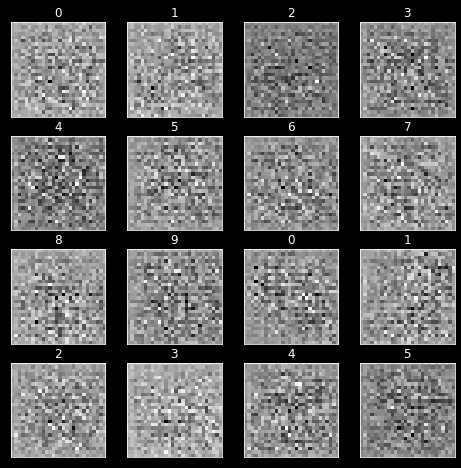

In [7]:
tf.random.set_seed(0)

cgan = ConditionalGAN(noise_dim=100)

noise_for_images_during_training = tf.random.normal((16, 100))
labels_for_images_during_training = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5])

n_epochs = 100
n_batches = len(train_data)

generate_and_save_images(cgan, 0, noise=noise_for_images_during_training, labels=labels_for_images_during_training, save_img=True)

Epoch: 100/100  Batch:  469/469  gen_loss:  0.79530  disc_loss:  0.68599


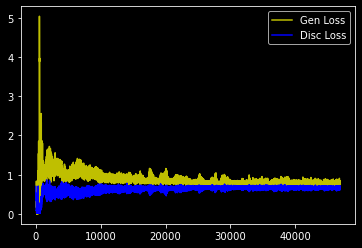

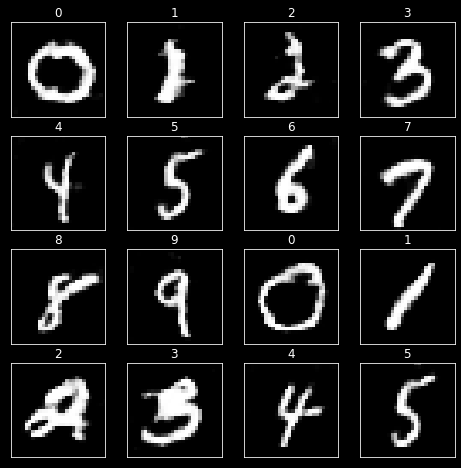

In [8]:
losses = []
for epoch in range(1, n_epochs + 1):
  for i, (real_images, real_labels) in enumerate(train_data):
    gen_loss, disc_loss = cgan.train_step(real_images, real_labels)
    losses.append((gen_loss, disc_loss))

    if (i + 1) % 25 == 0 or (i + 1) == n_batches:
      clear_output(wait=True)
      print(f'Epoch: {epoch: >2}/{n_epochs}  Batch: {i + 1: >4}/{n_batches}  gen_loss: {gen_loss: .5f}  disc_loss: {disc_loss: .5f}')
      plot_losses(losses)
      generate_and_save_images(cgan, epoch, noise_for_images_during_training, labels_for_images_during_training, save_img=(epoch%5==0))
  
  if epoch % 5 == 0:
    cgan.save(f'epoch-{epoch}')

## Plot Losses

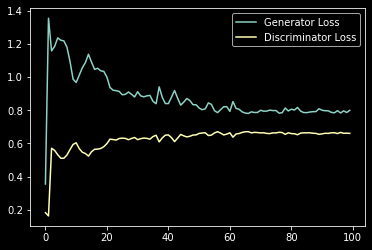

In [10]:
gen_losses, disc_losses = list(zip(*losses))
gen_losses = np.array(gen_losses).reshape((100, -1)).mean(axis=1)
disc_losses = np.array(disc_losses).reshape((100, -1)).mean(axis=1)

plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')

plt.legend()
plt.show()

Generate Samples after training

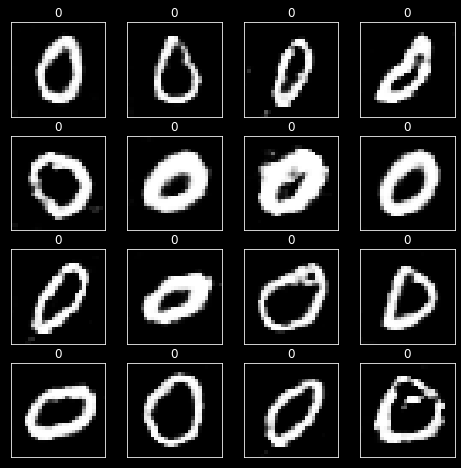

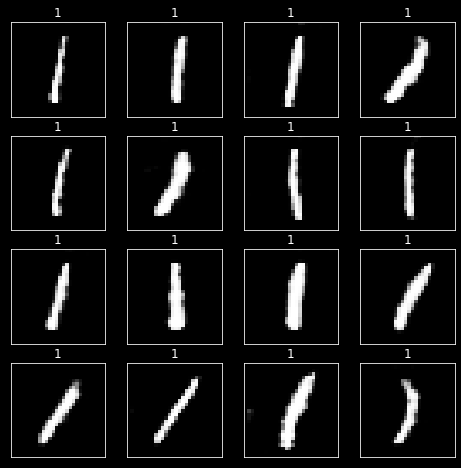

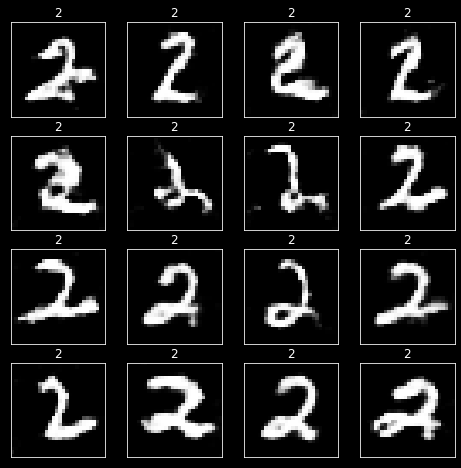

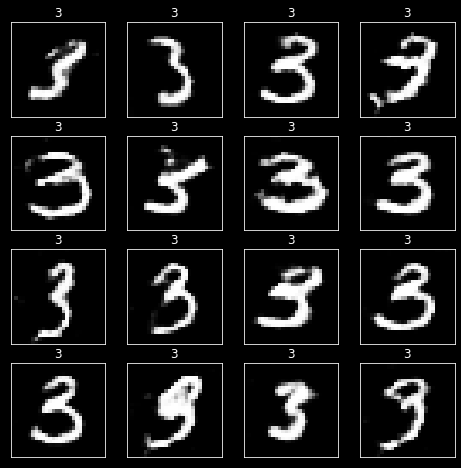

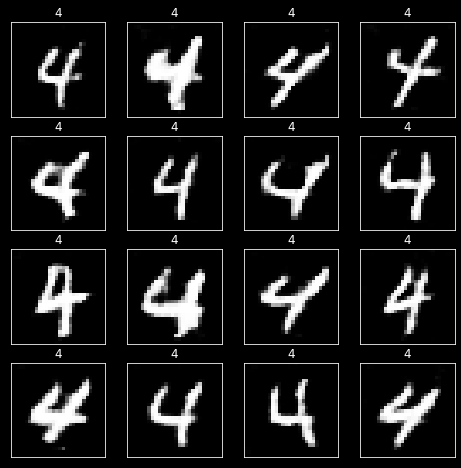

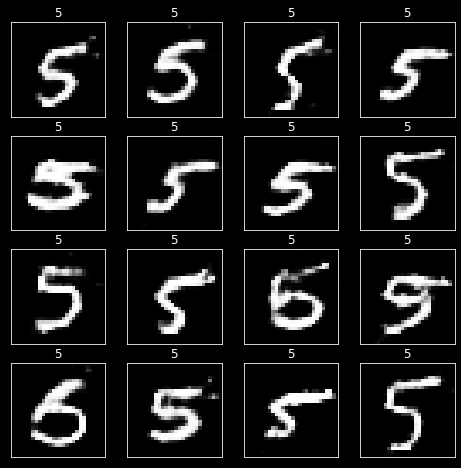

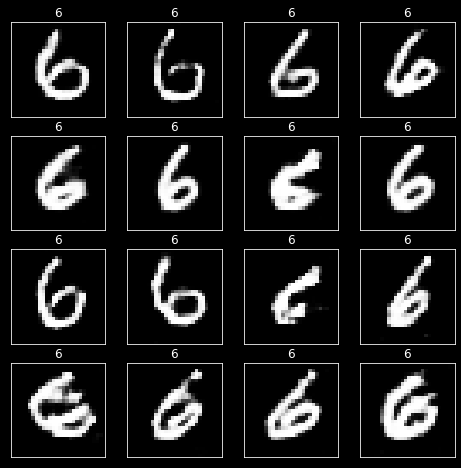

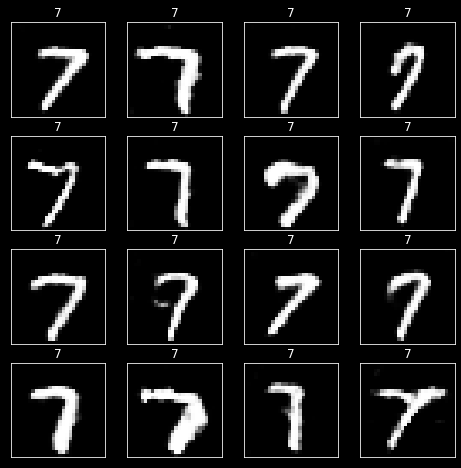

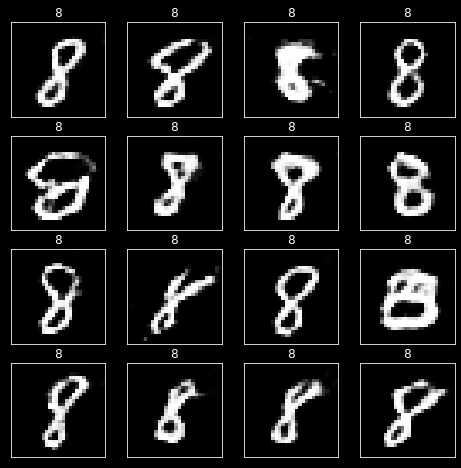

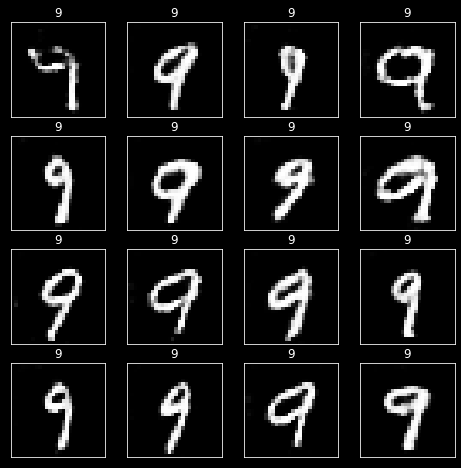

In [9]:
for i in range(10):
  noise = tf.random.normal((16, 100))
  labels = np.array([i] * 16)
  generate_and_save_images(cgan, i, noise, labels, save_img=True, folder='outputs')

## Generate Gif and Save Model

In [11]:
generate_gif()
cgan.save()